# Image classification

First, we build an image classification pipeline to differentiate between vehicle and non-vehicle images.

## Load images

In [1]:
import glob
import matplotlib.image as mpimg

def load_images(pattern):
    pathnames = glob.glob(pattern)
    return [mpimg.imread(x) for x in pathnames]

vehicles = load_images('data/vehicles/*/*.png')
non_vehicles = load_images('data/non-vehicles/*/*.png')

print('Loaded {} vehicle and {} non-vehicle images'.format(len(vehicles), len(non_vehicles)))

Loaded 8792 vehicle and 8968 non-vehicle images


## Extract features

In [2]:
import cv2
import numpy as np
from skimage.feature import hog

def extract_features(img, hog_orientations, hog_px_per_cell, hog_cells_per_block):
    """Extracts an unnormalized feature vectors from provided image"""
    
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    hog_features = hog(grayscale, hog_orientations, 
                       (hog_px_per_cell, hog_px_per_cell),
                       (hog_cells_per_block, hog_cells_per_block))
    
    return hog_features

# Feature extraction parameters
HOG_ORIENTATIONS = 9
HOG_PX_PER_CELL = 16
HOG_CELLS_PER_BLOCK = 2

vehicle_features = np.vstack([
    extract_features(image, HOG_ORIENTATIONS, HOG_PX_PER_CELL, HOG_CELLS_PER_BLOCK)
    for image in vehicles
])

non_vehicle_features = np.vstack([
    extract_features(image, HOG_ORIENTATIONS, HOG_PX_PER_CELL, HOG_CELLS_PER_BLOCK)
    for image in non_vehicles
])

print('Number of features: {}'.format(vehicle_features.shape[1]))

/home/goldob/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of features: 324


## Split data into training & test sets

In [3]:
from sklearn.model_selection import train_test_split

# Use constant seed so that the train-test split remains the same between consecutive executions
SEED = 533343803

X = np.vstack([vehicle_features, non_vehicle_features])
y = np.hstack([np.ones(len(vehicles)), np.zeros(len(non_vehicles))])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

## Normalize features

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Train the classifier

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC()
clf = GridSearchCV(svc, [
    {'kernel': ['linear']},
    {'kernel': ['rbf'], 'C': [0.5, 1.0, 2.0]}
])
clf.fit(X_train, y_train)

print('Training accuracy: {:.3%}'.format(clf.score(X_train, y_train)))
print('Test accuracy: {:.3%}'.format(clf.score(X_test, y_test)))

Training accuracy: 99.857%
Test accuracy: 98.806%


# Vehicle detection

Being able to correctly classify images, we can now search for cars on a larger scene.

## Load reference image

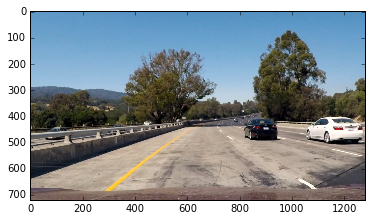

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# Divide by 255 to normalize pixel values
image = mpimg.imread('test_images/test1.jpg') / 255
image = np.float32(image)

plt.imshow(image)
plt.show()

## Implement sliding window algorithm

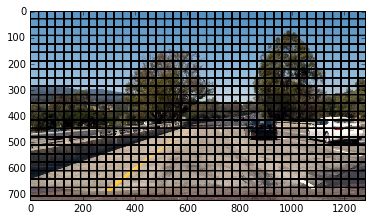

In [7]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """Draw bounding boxes for all window positions"""
    
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """Compute positions of a sliding window with given parameters"""
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None: x_start_stop[0] = 0
    if y_start_stop[0] == None: y_start_stop[0] = 0
    if x_start_stop[1] == None: x_start_stop[1] = img.shape[1]
    if y_start_stop[1] == None: y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    x_pix_per_step = int(xy_window[0] * (1 - xy_overlap[0]))
    y_pix_per_step = int(xy_window[1] * (1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    x_windows = int(1 + ((x_span - xy_window[0]) / x_pix_per_step))
    y_windows = int(1 + ((y_span - xy_window[1]) / y_pix_per_step))
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ny in range(y_windows):
        for nx in range(x_windows):

            # Calculate each window position
            x1 = x_start_stop[0] + nx*x_pix_per_step
            y1 = y_start_stop[0] + ny*y_pix_per_step
            
            x2 = x1 + xy_window[0]
            y2 = y1 + xy_window[1]
            
            # Append window position to list
            window_list.append(((x1, y1), (x2, y2)))
            
    # Return the list of windows
    return window_list

bboxes = slide_window(image)
bboxes_image = draw_boxes(image, bboxes)

plt.imshow(bboxes_image)
plt.show()

## Run sliding window multiple times with different size and limits

Window positions: 46


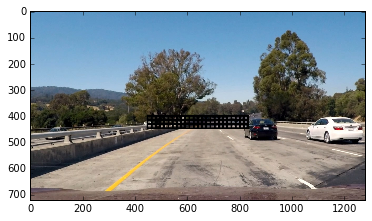

Window positions: 135


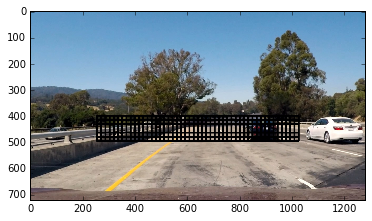

Window positions: 100


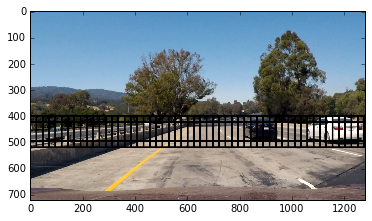

In [8]:
import pandas as pd

WINDOW_CONFIGS = [
    {
        'xy_window': [32, 32],
        'x_start_stop': [447, 831],
        'y_start_stop': [400, 448]
    },
    {
        'xy_window': [64, 64],
        'y_start_stop': [400, 496],
        'x_start_stop': [255, 1023],
        'xy_overlap': [0.75, 0.75]
    },
    {
        'xy_window': [96, 96],
        'y_start_stop': [400, 528],
        'xy_overlap': [0.75, 0.75]
    }
]

for config in WINDOW_CONFIGS:
    bboxes = slide_window(image, **config)
    bboxes_image = draw_boxes(image, bboxes)
    print('Window positions: {}'.format(len(bboxes)))
    plt.imshow(bboxes_image)
    plt.show()

## Detect cars running the sliding window with classifier

/home/goldob/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


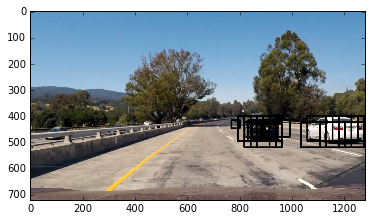

In [9]:
def detect_cars(img, window_configs):
    """Returns all sliding window positions for which a car is detected"""

    # Initialize a list to append positives' locations to
    detection_bboxes = []
    # Iterate over all sliding window configurations
    for config in window_configs:
        
        # Calculate window positions
        bboxes = slide_window(img, **config)
    
        # Iterate over all positions
        for v1, v2 in bboxes:
            # Crop out the image under current window
            window_img = img[v1[1]:v2[1], v1[0]:v2[0], :]
            
            # Resize
            window_img = cv2.resize(window_img, (64, 64))
            
            # Extract & normalize features
            features = extract_features(window_img, HOG_ORIENTATIONS, HOG_PX_PER_CELL, HOG_CELLS_PER_BLOCK)
            features = scaler.transform([features])[0]
            
            # Feed features to classifier
            car_detected = clf.predict([features])[0]
            
            if car_detected: detection_bboxes.append([v1, v2])
    
    return detection_bboxes
            
bboxes = detect_cars(image, WINDOW_CONFIGS)
bboxes_image = draw_boxes(image, bboxes)
plt.imshow(bboxes_image)
plt.show()

# Adjust the pipeline to handle streams of images

## Create a heatmap from the list of detections

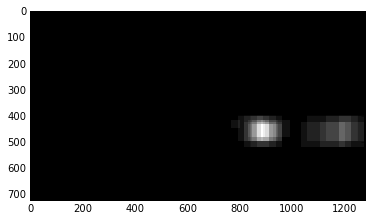

In [10]:
def get_heatmap(img, bbox_list):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

heatmap = get_heatmap(image, bboxes)

plt.imshow(heatmap, cmap='gray')
plt.show()

## Threshold heatmap to exclude false positives

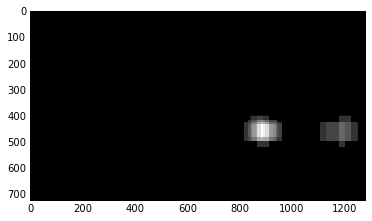

In [11]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

apply_threshold(heatmap, 2)
plt.imshow(heatmap, cmap='gray')
plt.show()

## Mark remaining detections with bounding boxes

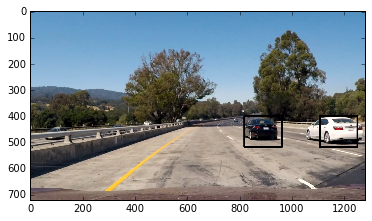

In [12]:
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

labels = label(heatmap)
plt.imshow(draw_labeled_bboxes(image, labels))
plt.show()

In [13]:
HISTORY_DEPTH = 7
history = [[] for i in range(HISTORY_DEPTH)]

HEATMAP_THRESHOLD = 11

def append_to_history(bbox_list, hist, depth):
    for i in range(depth - 1):
        history[depth-i-1] = history[depth-i-2]
    history[0] = bbox_list

def pipeline(img):
    img = np.float32(img / 255.0)
    
    bboxes = detect_cars(img, WINDOW_CONFIGS)
    append_to_history(bboxes, history, HISTORY_DEPTH)
    all_bboxes = sum(history, [])
    
    heatmap = get_heatmap(img, all_bboxes)
    
    heatmap_img = np.dstack([heatmap, heatmap, heatmap])
    heatmap_img = heatmap_img / heatmap_img.max()
    
    apply_threshold(heatmap, HEATMAP_THRESHOLD)
    labels = label(heatmap)
    
    img = 0.5 * img + 0.5 * heatmap_img
    return draw_labeled_bboxes(img * 255, labels)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


 95%|█████████▌| 1203/1261 [10:40<00:30,  1.88it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))